In [1]:
from main import *
from useful_functions import *
from visualization import *

from scipy.stats import ttest_ind
import bct
import seaborn

%matplotlib inline
plt.rcParams['font.size'] = 6

Todolist:
- Evaluate more # of communities (until null model beats real data)
- Compare best modularity maximization results with hierarchical clustering results

# Setting paths

In [2]:
top_directory = '/media/anleg84/Backup Plus/CERVO/Data/Networks2024/'
atlas_path = '/home/anleg84/Documents/Atlas/Mapzebrain/'

In [3]:
atlas = MapzebrainAtlas(atlas_path)
centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
centroids[:, 1] = 974 - centroids[:, 1]
excluded = np.load('Results/excluded_regions.npy')

centroids_ = np.delete(centroids, np.concatenate([excluded, excluded + 70]), axis=0)

In [4]:
datasets = get_datasets(top_directory, keywords=['920nm'], exclude=[])
print(len(datasets))

22


In [31]:
W_dir = np.load('Results/directed_terminals_expanded.npy')
W_und = np.load('Results/undirected_terminals_expanded.npy')
FC = np.load('Results/FC_matrix.npy')

In [32]:
delete = delete_rows_and_columns

# Structural communities

In [33]:
W = W_dir

In [34]:
compute = False
if compute:
    coassignment_matrix_SC = compute_coassignment_probability(W, N_iters=10000, threshold=False)
    np.save('Results/coassignment_matrix_SC_expanded.npy', coassignment_matrix_SC)
else:
    coassignment_matrix_SC = np.load('Results/coassignment_matrix_SC_expanded.npy')

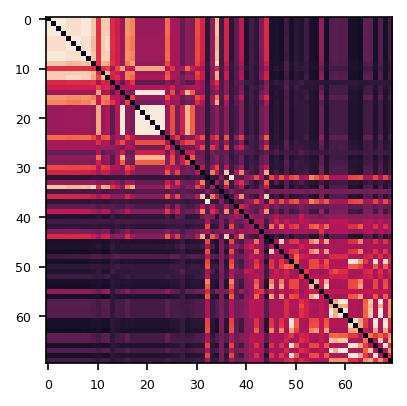

In [35]:
plt.figure(figsize=(3, 3), dpi=150)
plt.imshow(coassignment_matrix_SC, cmap='rocket')

#### Computing communities using hierarchical clustering

In [39]:
C = coassignment_matrix_SC
Z = linkage(1-C, 'ward')
communities = reorder_clusters_anteroposterior(fcluster(Z, t=4, criterion='maxclust'))

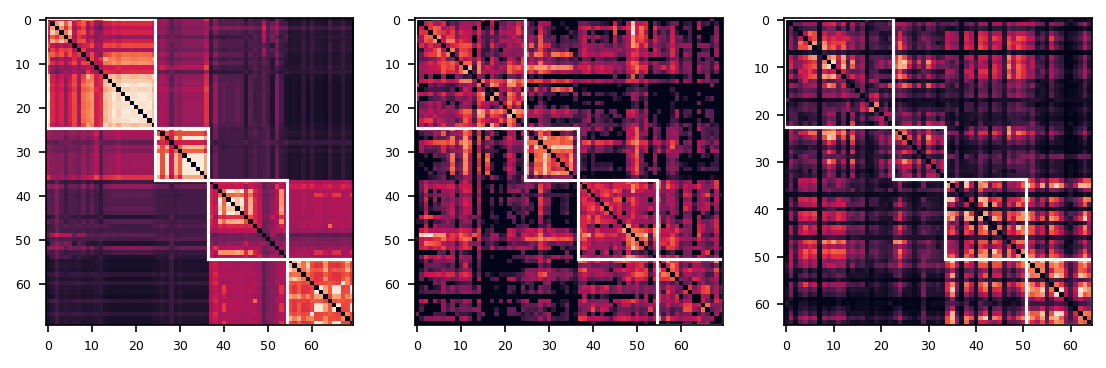

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
plot_matrix_communities(ax[0], C, communities, linewidth=1.5, cmap='rocket', edgecolor='white')
plot_matrix_communities(ax[1], W_und ** 2, communities, linewidth=1.5, cmap='rocket', edgecolor='white')
plot_matrix_communities(ax[2], FC ** 2, np.delete(communities, excluded), linewidth=1.5, cmap='rocket', edgecolor='white')

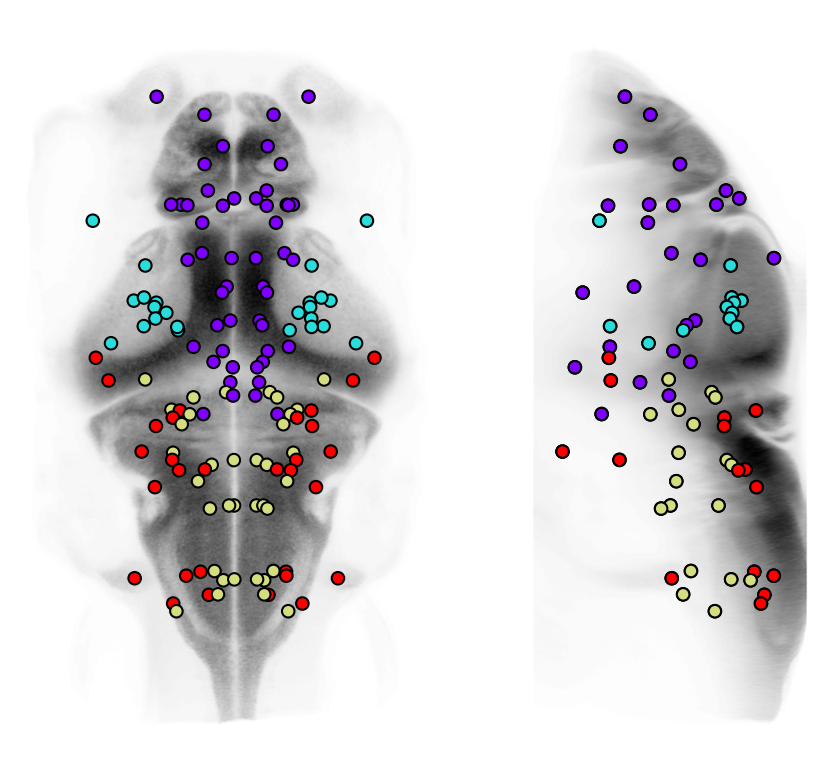

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5), dpi=150)
ax[0].imshow(atlas.XYprojection, cmap='binary')
ax[0].scatter(centroids[:, 0], centroids[:, 1], edgecolor='black', c=double(communities), cmap='rainbow')
ax[1].imshow(np.rot90(atlas.XZprojection, k=3), cmap='binary')
ax[1].scatter(359 - centroids[:, 2], centroids[:, 1], edgecolor='black', c=double(communities), cmap='rainbow')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout(pad=0)

#### Maximal number of communities before singlet appears

In [42]:
singlets = []
for t in np.arange(2, 71):
    communities = reorder_clusters_anteroposterior(fcluster(Z, t=t, criterion='maxclust'))
    any_singlet = np.any(np.unique(communities, return_counts=True)[1] == 1)
    singlets.append(any_singlet)

In [43]:
N_max_SC = np.arange(2, 71)[np.where(singlets)[0][0]] - 1
print(N_max_SC)

10


# Functional communities

In [44]:
W = FC

In [45]:
compute = False
if compute:
    coassignment_matrix_FC = compute_coassignment_probability(W, N_iters=10000, threshold=False)
    np.save('Results/coassignment_matrix_FC.npy', coassignment_matrix_FC)
else:
    coassignment_matrix_FC = np.load('Results/coassignment_matrix_FC.npy')

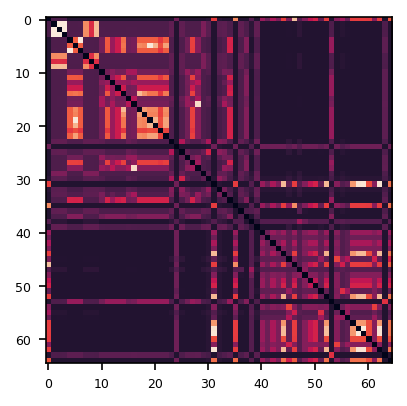

In [46]:
plt.figure(figsize=(3, 3), dpi=150)
plt.imshow(coassignment_matrix_FC, cmap='rocket')

In [47]:
C = coassignment_matrix_FC
Z = linkage(1-C, 'ward')
communities = reorder_clusters_anteroposterior(fcluster(Z, t=4, criterion='maxclust'))

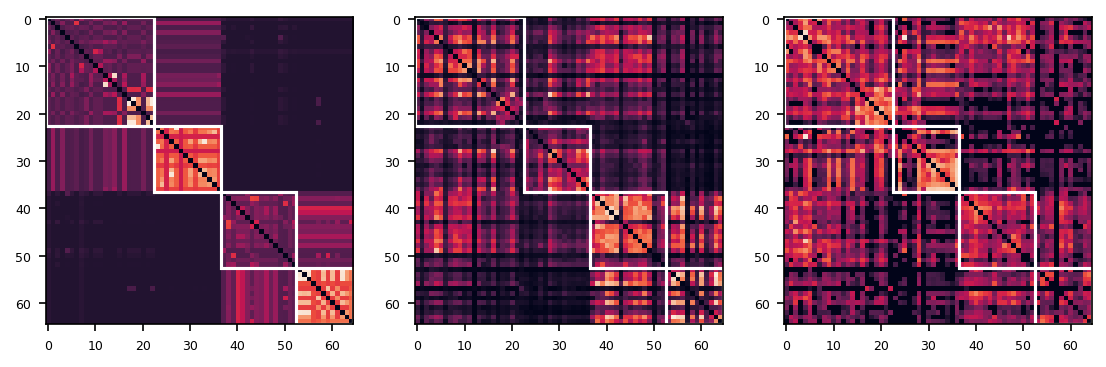

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
plot_matrix_communities(ax[0], C, communities, linewidth=1.5, cmap='rocket', edgecolor='white')
plot_matrix_communities(ax[1], FC ** 2, communities, linewidth=1.5, cmap='rocket', edgecolor='white')
plot_matrix_communities(ax[2], delete(W_und, excluded) ** 2, communities, linewidth=1.5, cmap='rocket', edgecolor='white')

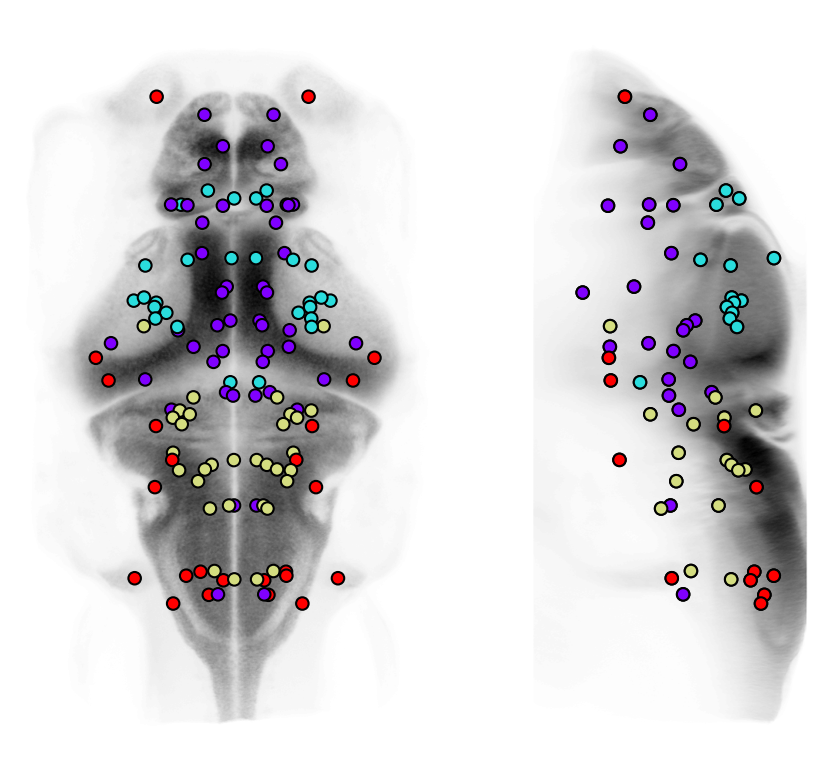

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5), dpi=150)
ax[0].imshow(atlas.XYprojection, cmap='binary')
ax[0].scatter(centroids_[:, 0], centroids_[:, 1], edgecolor='black', c=double(communities), cmap='rainbow')
ax[1].imshow(np.rot90(atlas.XZprojection, k=3), cmap='binary')
ax[1].scatter(359 - centroids_[:, 2], centroids_[:, 1], edgecolor='black', c=double(communities), cmap='rainbow')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout(pad=0)

In [50]:
singlets = []
for t in np.arange(2, 65):
    communities = reorder_clusters_anteroposterior(fcluster(Z, t=t, criterion='maxclust'))
    any_singlet = np.any(np.unique(communities, return_counts=True)[1] == 1)
    singlets.append(any_singlet)

In [51]:
N_max_FC = np.arange(2, 65)[np.where(singlets)[0][0]] - 1
print(N_max_FC)

7


# SCCM communities

In [25]:
SC_SCCM = np.load('Results/null_SC_expanded_deltaD_30.npy')

compute = False
if compute:
    coassignment_null = []
    for s in SC_SCCM[:50]:
        C = compute_coassignment_probability(s, N_iters=1000, threshold=False)
        coassignment_null.append(C)
    np.save('Results/coassignment_SCCM_expanded.npy', np.stack(coassignment_null))
else:
    coassignment_SCCM = np.load('Results/coassignment_SCCM_expanded.npy')

In [26]:
C = coassignment_SCCM[0]
Z = linkage(1-C, 'ward')
communities = reorder_clusters_anteroposterior(fcluster(Z, t=4, criterion='maxclust'))
ids = np.argsort(communities)

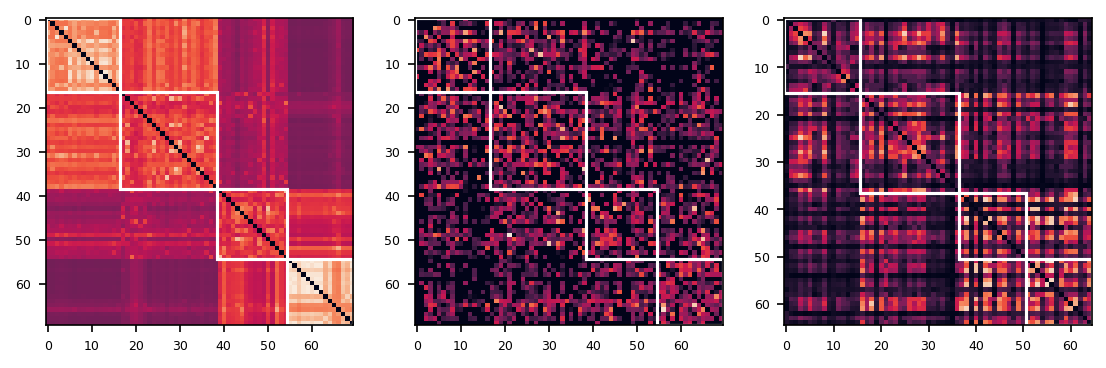

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
plot_matrix_communities(ax[0], C, communities, linewidth=1.5, cmap='rocket', edgecolor='white')
plot_matrix_communities(ax[1], SC_SCCM[0] ** 2, communities, linewidth=1.5, cmap='rocket', edgecolor='white')
plot_matrix_communities(ax[2], FC ** 2, np.delete(communities, excluded), linewidth=1.5, cmap='rocket', edgecolor='white')

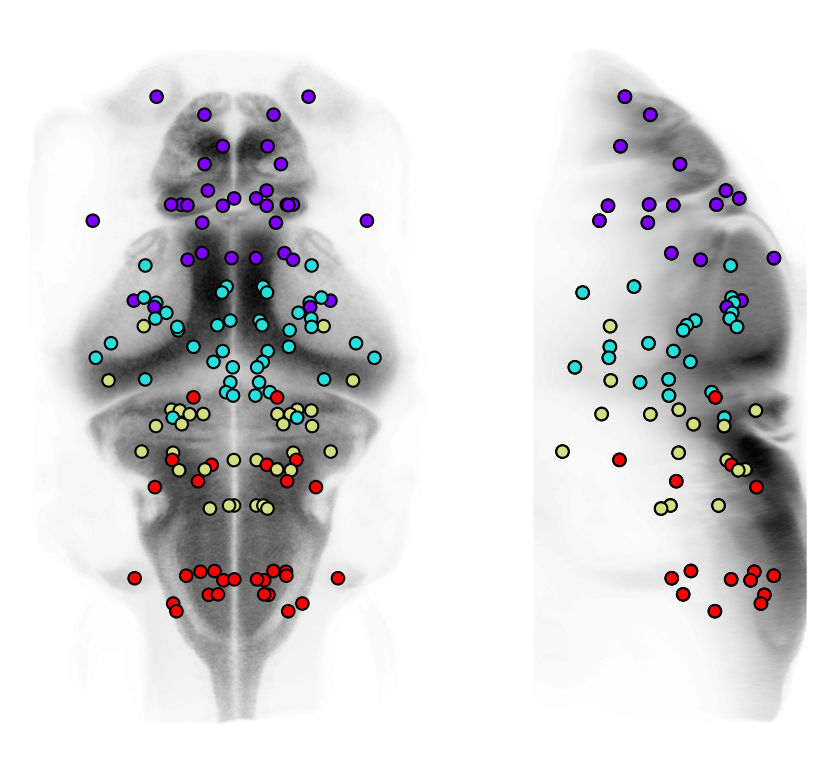

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5), dpi=150)
ax[0].imshow(atlas.XYprojection, cmap='binary')
ax[0].scatter(centroids[:, 0], centroids[:, 1], edgecolor='black', c=double(communities), cmap='rainbow')
ax[1].imshow(np.rot90(atlas.XZprojection, k=3), cmap='binary')
ax[1].scatter(359 - centroids[:, 2], centroids[:, 1], edgecolor='black', c=double(communities), cmap='rainbow')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout(pad=0)

# Configuration model communities

In [29]:
SC_CM = np.load('Results/null_SC_expanded_CM.npy')

compute = False
if compute:
    coassignment_null = []
    for s in SC_CM[:50]:
        C = compute_coassignment_probability(s, N_iters=2500, threshold=False)
        coassignment_null.append(C)
    np.save('Results/coassignment_CM_expanded.npy', np.stack(coassignment_null))
else:
    coassignment_CM = np.load('Results/coassignment_CM_expanded.npy')

In [30]:
C = coassignment_CM[0]
Z = linkage(1-C, 'ward')
communities = reorder_clusters_anteroposterior(fcluster(Z, t=4, criterion='maxclust'))
ids = np.argsort(communities)

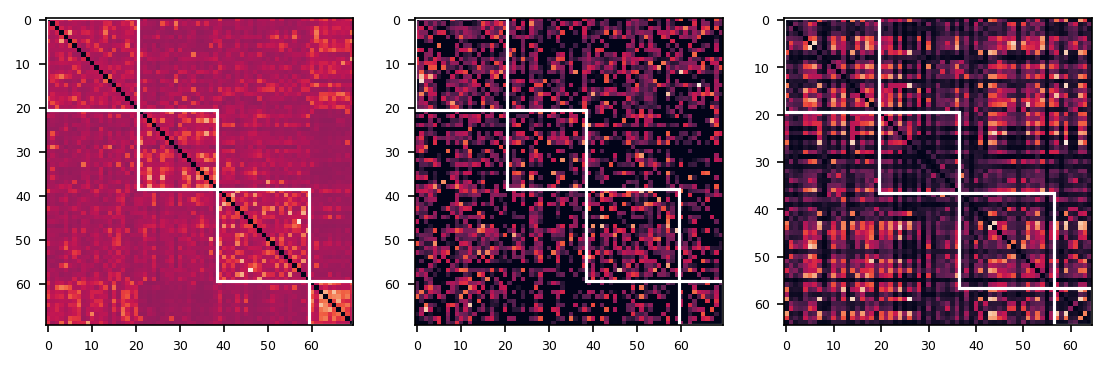

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
plot_matrix_communities(ax[0], C, communities, linewidth=1.5, cmap='rocket', edgecolor='white')
plot_matrix_communities(ax[1], SC_CM[0] ** 2, communities, linewidth=1.5, cmap='rocket', edgecolor='white')
plot_matrix_communities(ax[2], FC ** 2, np.delete(communities, excluded), linewidth=1.5, cmap='rocket', edgecolor='white')

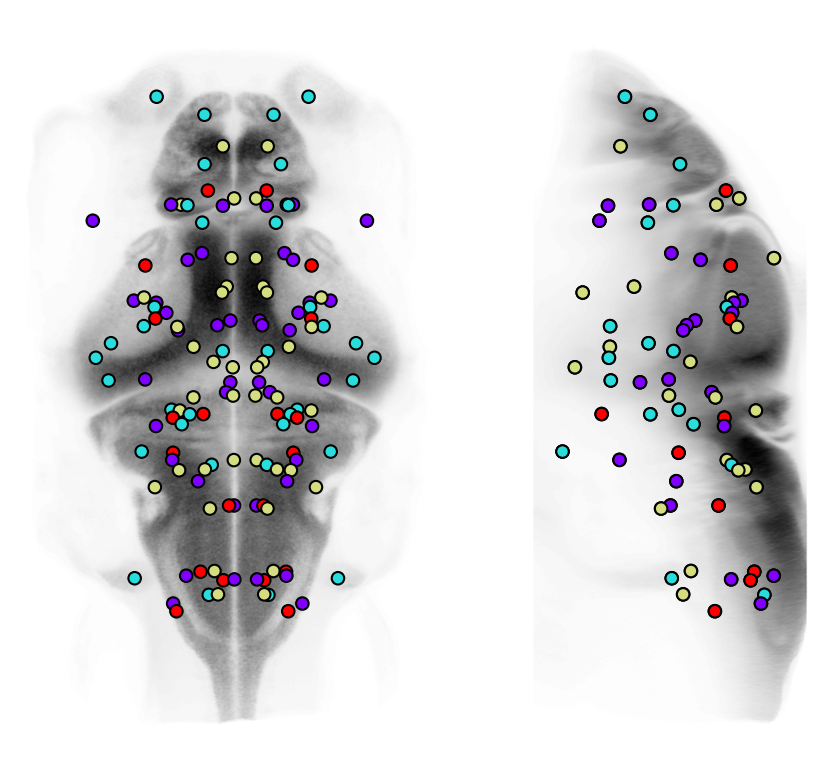

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5), dpi=150)
ax[0].imshow(atlas.XYprojection, cmap='binary')
ax[0].scatter(centroids[:, 0], centroids[:, 1], edgecolor='black', c=double(communities), cmap='rainbow')
ax[1].imshow(np.rot90(atlas.XZprojection, k=3), cmap='binary')
ax[1].scatter(359 - centroids[:, 2], centroids[:, 1], edgecolor='black', c=double(communities), cmap='rainbow')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout(pad=0)

# Phase-randomized FC communities

In [33]:
FC_null = np.load('Results/null_FC_matrices.npy')

compute = False
if compute:
    coassignment_null = []
    for m in FC_null[:10]:
        C = compute_coassignment_probability(m, N_iters=2500, threshold=False)
        coassignment_null.append(C)
    np.save('Results/coassignment_FC_null.npy', np.stack(coassignment_null))
else:
    coassignment_FC_null = np.load('Results/coassignment_FC_null.npy')

In [34]:
C = coassignment_FC_null[0]
Z = linkage(1-C, 'ward')
communities = reorder_clusters_anteroposterior(fcluster(Z, t=4, criterion='maxclust'))
ids = np.argsort(communities)

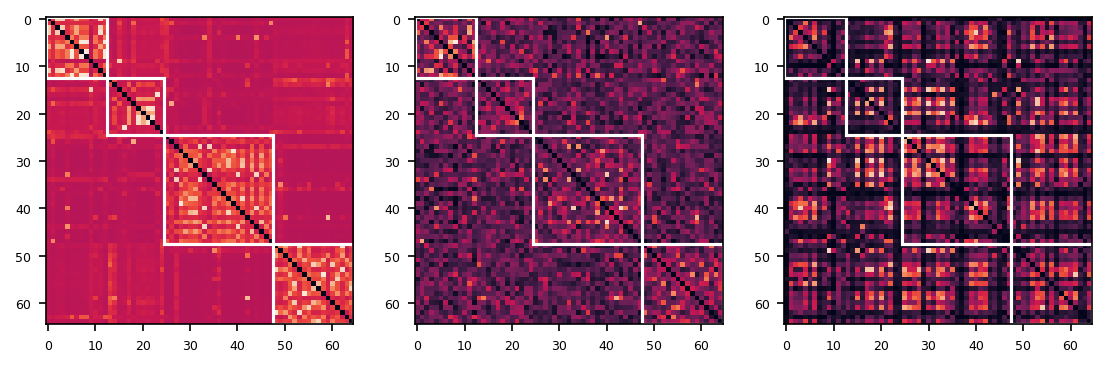

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
plot_matrix_communities(ax[0], C, communities, linewidth=1.5, cmap='rocket', edgecolor='white')
plot_matrix_communities(ax[1], FC_null[0] ** 2, communities, linewidth=1.5, cmap='rocket', edgecolor='white')
plot_matrix_communities(ax[2], FC ** 2, communities, linewidth=1.5, cmap='rocket', edgecolor='white')

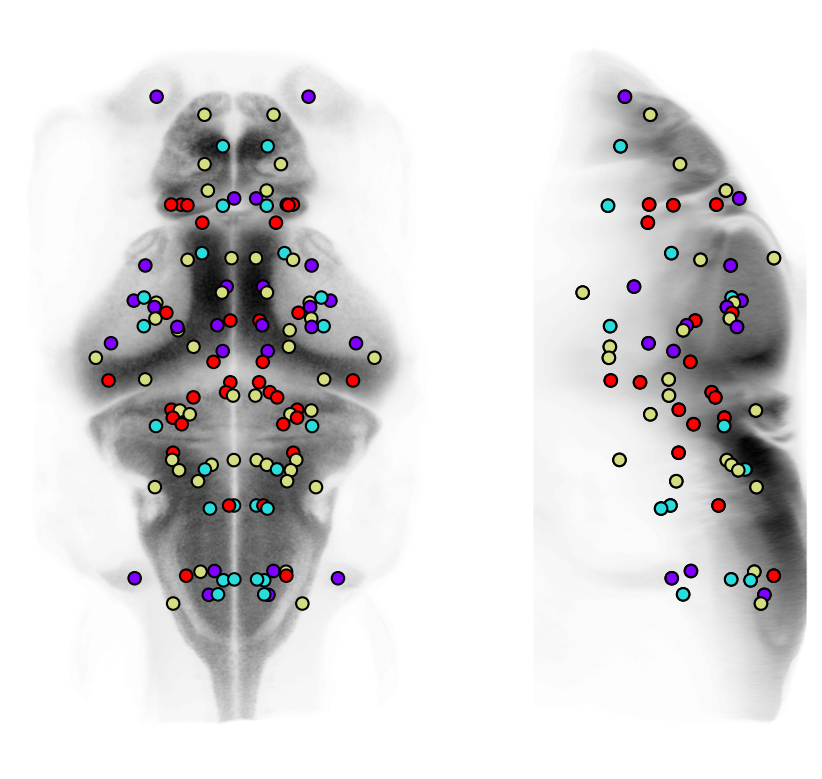

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5), dpi=150)
ax[0].imshow(atlas.XYprojection, cmap='binary')
ax[0].scatter(centroids_[:, 0], centroids_[:, 1], edgecolor='black', c=double(communities), cmap='rainbow')
ax[1].imshow(np.rot90(atlas.XZprojection, k=3), cmap='binary')
ax[1].scatter(359 - centroids_[:, 2], centroids_[:, 1], edgecolor='black', c=double(communities), cmap='rainbow')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout(pad=0)

# Optimal number of communities and induced modularity

In [166]:
def modularity_score_nx(adjacency_matrix, community_labels):
    G = nx.from_numpy_array(adjacency_matrix)
    communities = get_communities_sets(community_labels)
    return nx.community.modularity(G, communities)

In [167]:
def get_communities_sets(vector):
    communities = []
    for c in np.unique(vector):
        communities.append(set(np.where(vector == c)[0]))
    return communities

@njit
def modularity_score(adjacency_matrix, community_labels):
    m = adjacency_matrix.sum() / 2 
    degrees = adjacency_matrix.sum(axis=1)
    modularity = 0.0
    for i in range(adjacency_matrix.shape[0]):
        for j in range(adjacency_matrix.shape[1]):
            if community_labels[i] == community_labels[j]:
                modularity += adjacency_matrix[i, j] - (degrees[i] * degrees[j]) / (2 * m)
    return modularity / (2 * m)

def compute_modularity_curve(coassignment, matrix, excluded=None, N_min=2, N_max=10, linkage_method='ward'):
    if excluded is None:
        excluded = []
    Q_values = []
    for N in range(N_min, N_max + 1):
        Z = linkage(1 - coassignment, linkage_method)
        communities = reorder_clusters_anteroposterior(fcluster(Z, t=N, criterion='maxclust'))
        Q = modularity_score_nx(matrix, np.delete(communities, excluded))
        Q_values.append(Q)
    return np.array(Q_values)

def compute_modularity_shuffled(coassignment, matrix, excluded=None, N_min=2, N_max=10, N_shuffles=1000, linkage_method='ward'):
    if excluded is None:
        excluded = []
    Q_values_shuffled = []
    for N in range(N_min, N_max + 1):
        Z = linkage(1 - coassignment, linkage_method)
        communities = reorder_clusters_anteroposterior(fcluster(Z, t=N, criterion='maxclust'))
        ids = np.arange(matrix.shape[0])
        Q_values_shuffled_ = []
        for _ in range(1000):
            np.random.shuffle(ids)
            reordered = matrix[ids, :][:, ids]
            Q = modularity_score_nx(reordered, np.delete(communities, excluded))
            Q_values_shuffled_.append(Q)
        Q_values_shuffled.append(np.array(Q_values_shuffled_))
    return np.array(Q_values_shuffled)

#### Modularity of SC

In [175]:
N_max = N_max_SC

C = coassignment_matrix_SC

# 1. Modularity at each hierarchical level
modularity_SC = compute_modularity_curve(C, W_dir, excluded=None, N_max=N_max)

# 2. Modularity when community labels are shuffled
modularity_SC_shuffled = np.percentile(compute_modularity_shuffled(C, W_dir, excluded=None, N_max=N_max), 99, axis=1)

# 3. Modularity of Structurally Constrained Configuration Model
modularities_SCCM = []
for i, C in enumerate(coassignment_SCCM):
    Q = compute_modularity_curve(C, SC_SCCM[i], excluded=None, N_max=N_max)
    modularities_SCCM.append(Q)
modularity_SCCM = np.percentile(np.stack(modularities_SCCM), 99, axis=0)

# 4. Modularity of Configuration Model
modularities_CM = []
for i, C in enumerate(coassignment_CM):
    Q = compute_modularity_curve(C, SC_CM[i], excluded=None, N_max=N_max)
    modularities_CM.append(Q)
modularity_CM = np.percentile(np.stack(modularities_CM), 99, axis=0)

In [178]:
N_communities = np.arange(2, N_max_SC + 1)

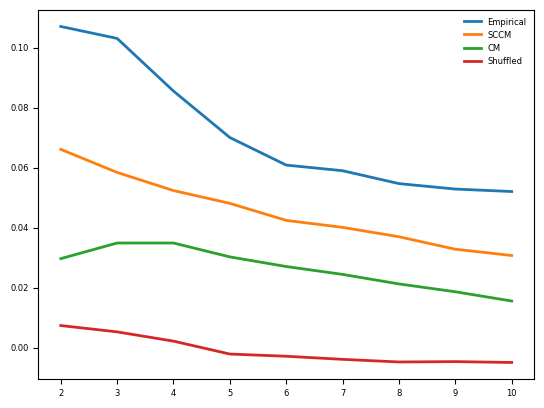

In [179]:
plt.plot(N_communities, modularity_SC, linewidth=2, label='Empirical')
plt.plot(N_communities, modularity_SCCM, linewidth=2, label='SCCM')
plt.plot(N_communities, modularity_CM, linewidth=2, label='CM')
plt.plot(N_communities, modularity_SC_shuffled, linewidth=2, label='Shuffled')
plt.legend(frameon=False)

In [37]:
array = np.stack([modularity_SC, modularity_SCCM, modularity_CM, modularity_SC_shuffled], axis=0)
np.save('Results/figure3_modularities_SC.npy', array)

#### Modularity of FC

In [173]:
C = coassignment_matrix_FC

modularity_FC = compute_modularity_curve(coassignment_matrix_FC, FC, excluded=None, N_max=N_max_FC)

modularities_FC_null = []
for i, C in enumerate(coassignment_FC_null):
    Q = compute_modularity_curve(C, FC_null[i], excluded=None, N_max=N_max_FC)
    modularities_FC_null.append(Q)
modularity_FC_null = np.percentile(np.stack(modularities_FC_null), 99, axis=0)

modularity_FC_shuffled = np.percentile(compute_modularity_shuffled(C, FC, excluded=None, N_max=N_max_FC), 99, axis=1)


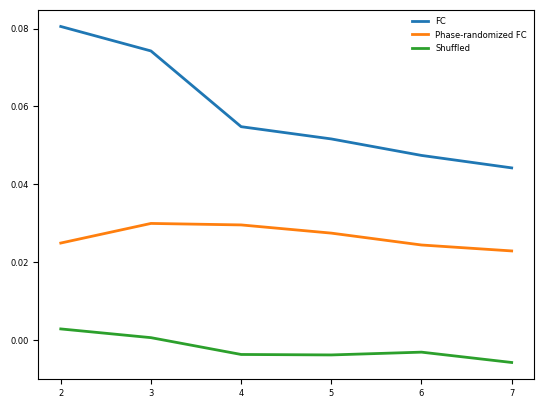

In [174]:
plt.plot(N_communities, modularity_FC, linewidth=2, label='FC')
plt.plot(N_communities, modularity_FC_null, linewidth=2, label='Phase-randomized FC')
plt.plot(N_communities, modularity_FC_shuffled, linewidth=2, label='Shuffled')
plt.legend(frameon=False)

In [40]:
array = np.stack([modularity_FC, modularity_FC_null, modularity_FC_shuffled], axis=0)
np.save('Results/figure3_modularities_FC.npy', array)

# Communities labels overlap

In [45]:
method = 'Rand'
linkage_method = 'ward'

In [180]:
N_communities = np.arange(2, N_max_FC + 1)

In [181]:
scores_empirical = compute_communities_overlap_curve(coassignment_matrix_FC,
                                    coassignment_matrix_SC,
                                    excluded=excluded,
                                    method=method,
                                    linkage_method=linkage_method,
                                    N_communities=N_communities)

scores_shuffled = compute_communities_overlap_curve_shuffled(coassignment_matrix_FC,
                                    coassignment_matrix_SC,
                                    excluded=excluded,
                                    method=method,
                                    linkage_method=linkage_method,
                                    N_communities=N_communities)

scores_SCCM = []
for C in coassignment_SCCM:
    scores = compute_communities_overlap_curve(coassignment_matrix_FC,
                                        C,
                                        excluded=excluded,
                                        method=method,
                                        linkage_method=linkage_method,
                                        N_communities=N_communities)
    scores_SCCM.append(scores)

scores_CM = []
for C in coassignment_CM:
    scores = compute_communities_overlap_curve(coassignment_matrix_FC,
                                        C,
                                        excluded=excluded,
                                        method=method,
                                        linkage_method=linkage_method,
                                        N_communities=N_communities)
    scores_CM.append(scores)

scores_PR = []
for C in coassignment_FC_null:
    scores = compute_communities_overlap_curve(C,
                                        coassignment_matrix_SC,
                                        excluded=excluded,
                                        method=method,
                                        linkage_method=linkage_method,
                                        N_communities=N_communities)
    scores_PR.append(scores)

scores_99_shuffled = np.percentile(np.stack(scores_shuffled), 99, axis=1)
scores_99_CM = np.percentile(np.stack(scores_CM), 99, axis=0)
scores_99_SCCM = np.percentile(np.stack(scores_SCCM), 99, axis=0)
scores_99_PR = np.percentile(np.stack(scores_PR), 99, axis=0)

100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.04it/s]


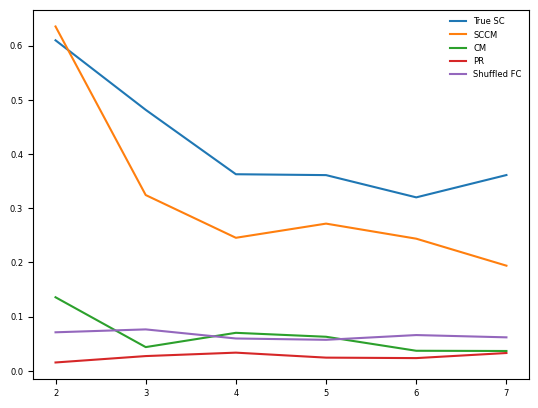

In [182]:
plt.plot(N_communities, scores_empirical, label='True SC')
plt.plot(N_communities, scores_99_SCCM, label='SCCM')
plt.plot(N_communities, scores_99_CM, label='CM')
plt.plot(N_communities, scores_99_PR, label='PR')

plt.plot(N_communities, scores_99_shuffled, label='Shuffled FC')


plt.legend(frameon=False)

In [44]:
array = np.stack([scores_empirical, scores_99_SCCM, scores_99_CM, scores_99_PR, scores_99_shuffled])
np.save('Results/figure3_overlaps.npy', array)

In [183]:
communities_SC = []
for N in N_communities:
    Z = linkage(1 - coassignment_matrix_SC, 'ward')
    labels = reorder_clusters_anteroposterior(fcluster(Z, t=N, criterion='maxclust'))
    communities_SC.append(labels / np.max(labels))

communities_FC = []
for N in N_communities:
    Z = linkage(1 - coassignment_matrix_FC, 'ward')
    labels = reorder_clusters_anteroposterior(fcluster(Z, t=N, criterion='maxclust'))
    communities_FC.append(labels / np.max(labels))

communities_SCCM = []
for N in N_communities:
    Z = linkage(1 - coassignment_SCCM[0], 'ward')
    labels = reorder_clusters_anteroposterior(fcluster(Z, t=N, criterion='maxclust'))
    communities_SCCM.append(labels / np.max(labels))

communities_CM = []
for N in N_communities:
    Z = linkage(1 - coassignment_CM[0], 'ward')
    labels = reorder_clusters_anteroposterior(fcluster(Z, t=N, criterion='maxclust'))
    communities_CM.append(labels / np.max(labels))

communities_PR = []
for N in N_communities:
    Z = linkage(1 - coassignment_FC_null[0], 'ward')
    labels = reorder_clusters_anteroposterior(fcluster(Z, t=N, criterion='maxclust'))
    communities_PR.append(labels / np.max(labels))

communities_shuffled = []
for N in N_communities:
    Z = linkage(1 - coassignment_matrix_FC, 'ward')
    labels = reorder_clusters_anteroposterior(fcluster(Z, t=N, criterion='maxclust'))
    np.random.shuffle(labels)
    communities_shuffled.append(labels / np.max(labels))

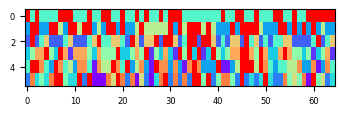

In [184]:
plt.figure(figsize=(4, 1))
plt.imshow(communities_shuffled, aspect='auto', interpolation='None', cmap='rainbow')

In [47]:
array = np.stack([np.delete(communities_SC, excluded, axis=1),
                  communities_FC,
                  np.delete(communities_SCCM, excluded, axis=1),
                  np.delete(communities_CM, excluded, axis=1),
                  communities_PR,
                  communities_shuffled], axis=0)
np.save('Results/figure3_communities_labels.npy', array)

# Spatial extent of communities

In [185]:
D = atlas.computeDistanceBetweenRegions()

In [186]:
def compute_intra_community_distances(communities, distances, excluded=None):
    if excluded is None:
        excluded = []
    communities = np.delete(communities, excluded)
    distances = delete(distances, excluded)
    intra_community_distances = []
    for c in np.unique(communities):
        ids_c = np.where(communities == c)[0]
        for i in range(len(ids_c)):
            for j in range(i + 1):
                i1, i2 = ids_c[i], ids_c[j]
                if i1 != i2:
                    intra_community_distances.append(distances[i1, i2])
    return intra_community_distances

In [188]:
bins = np.linspace(0, 600, 30)

In [189]:
def plot_smooth_histogram(ax, data, bins, N_interp=1000, sigma=20, density=False, color='black', edgecolor='black', alpha=1, linewidth=1, linestyle='-'):
    h1 = np.histogram(data, bins=bins, density=density)
    y1 = gaussian_filter1d(interpolate_signal(h1[0], N_interp), sigma)
    x1 = interpolate_signal(h1[1], N_interp)
    #ax.fill_between(x1, 0, y1, color=color, edgecolor='None', alpha=alpha)
    ax.plot(x1, y1, color=edgecolor, linewidth=linewidth, linestyle=linestyle)

In [190]:
distances_SC = []
distances_FC = []
distances_SCCM = []
distances_CM = []
distances_PR = []
distances_shuffled = []

for N_communities in np.arange(2, N_max_FC):

    Z = linkage(1 - coassignment_matrix_SC, 'ward')
    communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
    distances_SC.append(compute_intra_community_distances(communities, D, excluded=excluded))
    
    Z = linkage(1 - coassignment_matrix_FC, 'ward')
    communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
    distances_FC.append(compute_intra_community_distances(communities, D))
    
    #distances_SCCM = []
    for C in coassignment_SCCM:
        Z = linkage(1 - C, 'ward')
        communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
        distances = compute_intra_community_distances(communities, D, excluded=excluded)
        distances_SCCM.append(distances)
    #distances_SCCM = np.concatenate(distances_SCCM)
    
    #distances_CM = []
    for C in coassignment_CM:
        Z = linkage(1 - C, 'ward')
        communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
        distances = compute_intra_community_distances(communities, D, excluded=excluded)
        distances_CM.append(distances)
    #distances_CM = np.concatenate(distances_CM)
    
    #distances_PR = []
    for C in coassignment_FC_null:
        Z = linkage(1 - C, 'ward')
        communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
        distances = compute_intra_community_distances(communities, D, excluded=None)
        distances_PR.append(distances)
    #distances_PR = np.concatenate(distances_PR)
    
    #distances_shuffled = []
    for C in coassignment_FC_null:
        Z = linkage(1 - C, 'ward')
        communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
        np.random.shuffle(communities)
        distances = compute_intra_community_distances(communities, D, excluded=None)
        distances_shuffled.append(distances)
    #distances_shuffled = np.concatenate(distances_shuffled)
    
    #fig, ax = plt.subplots(figsize=(5, 5))
    #sigma = 50
    #plot_smooth_histogram(ax, distances_SC, bins, sigma=sigma, edgecolor='C0', alpha=1, density=True, linewidth=2)
    #plot_smooth_histogram(ax, distances_FC, bins, sigma=sigma, edgecolor='C1', alpha=1, density=True, linewidth=2)
    #plot_smooth_histogram(ax, distances_SCCM, bins, sigma=sigma, edgecolor='C2', alpha=1, density=True, linewidth=2, linestyle='--')
    #plot_smooth_histogram(ax, distances_CM, bins, sigma=sigma, edgecolor='C3', alpha=1, density=True, linewidth=2, linestyle='--')
    #plot_smooth_histogram(ax, distances_PR, bins, sigma=sigma, edgecolor='C4', alpha=1, density=True, linewidth=2, linestyle='--')
    #plot_smooth_histogram(ax, distances_shuffled, bins, sigma=sigma, edgecolor='C5', alpha=1, density=True, linewidth=2, linestyle='--')

In [191]:
distances_SC = np.concatenate(distances_SC)
distances_FC = np.concatenate(distances_FC)
distances_SCCM = np.concatenate(distances_SCCM)
distances_CM = np.concatenate(distances_CM)
distances_PR = np.concatenate(distances_PR)
distances_shuffled = np.concatenate(distances_shuffled)

In [38]:
np.save('Results/figure3_distances_SC.npy', distances_SC)
np.save('Results/figure3_distances_FC.npy', distances_FC)
np.save('Results/figure3_distances_SCCM.npy', distances_SCCM)
np.save('Results/figure3_distances_CM.npy', distances_CM)
np.save('Results/figure3_distances_PR.npy', distances_PR)
np.save('Results/figure3_distances_shuffled.npy', distances_shuffled)

In [192]:
colors = color_gradient([1, 0, 0], [1, 1, 1], 8)

Text(0, 0.5, 'Avg. network similarity')

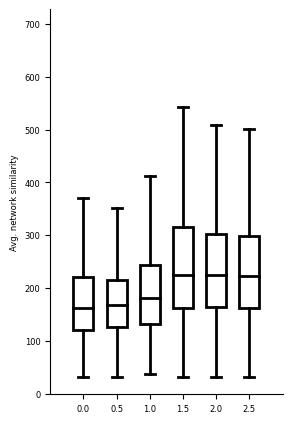

In [193]:
fig, ax = plt.subplots(figsize=(3, 5))

data = [distances_SC, distances_SCCM, distances_FC, distances_CM, distances_PR, distances_shuffled]

for i, distances in enumerate(data):
    #plt.scatter(np.random.normal(i / 2, 0.05, len(distances)), distances, color=colors[i], edgecolor='None', alpha=0.01)
    bp = ax.boxplot(distances, positions=[i / 2], patch_artist=True, widths=0.3)
    set_boxplot_color(bp, color='black', marker='None')
    
    
ax.spines[['top', 'right']].set_visible(False)
#ax.set_xticklabels(['Same', 'Different'], rotation=90)
plt.ylabel('Avg. network similarity')



# Participation coefficient

In [62]:
def plot_node_values(ax, values, atlas, excluded=None, view='top', double_vector=False, s=25, linewidth=1, cmap='hot', edgecolor='black'):
    if excluded is None:
        excluded = []
    if view == 'top':
        ax.imshow(atlas.XYprojection, cmap='gray')
        centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
        centroids[:, 1] = 974 - centroids[:, 1]
        if double_vector:
            values = double(values)
            if any(excluded):
                excluded = np.concatenate([excluded, excluded + 70])
        centroids = np.delete(centroids, excluded, axis=0)
        ax.scatter(centroids[:, 0], centroids[:, 1], cmap=cmap, c=values, linewidth=linewidth, s=s, edgecolor=edgecolor)
    if view == 'side':
        ax.imshow(atlas.XZprojection, cmap='gray')
        centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
        centroids[:, 1] = 974 - centroids[:, 1]
        if double_vector:
            values = double(values)
            if any(excluded):
                excluded = np.concatenate([excluded, excluded + 70])
        centroids = np.delete(centroids, excluded, axis=0)
        ax.scatter(centroids[:, 1], centroids[:, 2], cmap=cmap, c=values, linewidth=linewidth, s=s, edgecolor=edgecolor)

In [63]:
C = coassignment_matrix_SC
Z = linkage(1 - C, 'ward')

participations_SC = []
for N in np.arange(2, 11):
    communities = reorder_clusters_anteroposterior(fcluster(Z, t=N, criterion='maxclust'))
    participation = bct.participation_coef(W_dir, communities, degree='directed')
    participations_SC.append(participation)
participations_SC = np.stack(participations_SC)

C = coassignment_matrix_FC
Z = linkage(1 - C, 'ward')

participations_FC = []
for N in np.arange(2, 11):
    communities = reorder_clusters_anteroposterior(fcluster(Z, t=N, criterion='maxclust'))
    participation = bct.participation_coef(FC, communities, degree='undirected')
    participations_FC.append(participation)
participations_FC = np.stack(participations_FC)

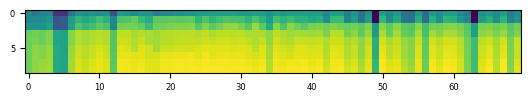

In [64]:
plt.imshow(participations_SC)

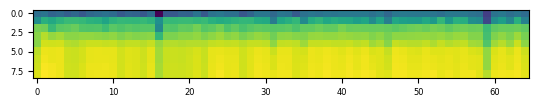

In [65]:
plt.imshow(participations_FC )

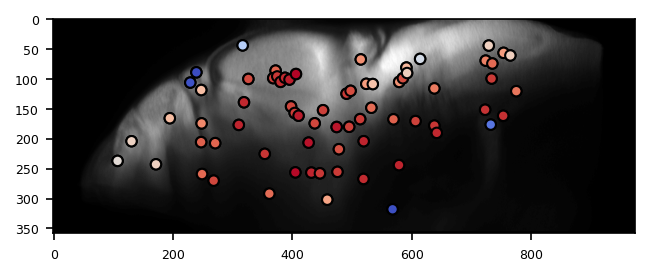

In [66]:
fig, ax = plt.subplots(figsize=(5, 7), dpi=150)
plot_node_values(ax, np.mean(participations_SC, axis=0), atlas, double_vector=True, cmap='coolwarm', view='side', excluded=None)